# Comercio electrónico: análisis de la gama de productos

Se procederá a realizar un análisis de la gama de productos de una tienda de artículos para el hogar, con el propósito de que esta pueda maximizar sus ingresos, desde una perspectiva de los productos en sí (¿Cuáles resultan más defectuosos o pueden provocar devoluciones?), así como desde la perspectiva de los hábitos de consumo de los clientes (¿Cómo suelen comprar los artículos los clientes?).

A continuación se despliegan los distintos apartados de este análisis:

* 1 - Carga de librerías, de base de datos e inspección inicial de información
* 2 - Preparación de los datos
* 3 - Análisis de los datos
     * 3.1 - Análisis de productos que han perdido popularidad
     * 3.2 - Análisis de productos por pérdidas y devoluciones
     * 3.3 - Análisis de productos por compra conjunta
* 4 - Conclusiones generales
* 5 - Comentarios sobre fuentes de información

Vínculo para presentación en PDF:
https://1drv.ms/b/s!AhPea--QqwlegcwalgWmlrwE2Lcgaw?e=ucdvcd

A continuación se encuentra el enlace para ver el Dashboard en Tableau:
https://public.tableau.com/views/EstudiodeVentaseIngresos/Dashboard1?:language=es-ES&publish=yes&:display_count=n&:origin=viz_share_link


## Carga de librerías y base de datos

Comenzaremos importando las librerías necesarias y cargando la información de la base. Posteriormente realizaremos un analisis inicial sobre lo encontrado.

In [172]:
#Importación de librerías

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats
from scipy import stats as st
from itertools import combinations
import math as mth

In [173]:
#Importación de tabla

try:
    data = pd.read_csv('ecommerce_dataset_us.csv', sep='\t')
except:
    data = pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep='\t')
                                   
display(data)
data.info()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,11/29/2018 08:26,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,11/29/2018 08:26,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,11/29/2018 08:26,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,11/29/2018 08:26,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,11/29/2018 08:26,3.39,17850.0
...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/07/2019 12:50,0.85,12680.0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/07/2019 12:50,2.10,12680.0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/07/2019 12:50,4.15,12680.0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/07/2019 12:50,4.15,12680.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB


A primera vista podemos observar la necesidad de cambiar el tipo de la columna de InvoiceDate y la de Costumer ID, para que contengan un valor con el que sea más fácil trabajar de fecha y el identificador de usuario como entero, ya que no hacen falta los decimales. Además de esto es importante cambiar los nombres de las columnas para que cumplan con las mejores prácticas.

Existen valores ausentes en las columnas de descripción e identificador de cliente, las cuales habrá que estudiar la razón por las que faltan y tratarlos de la manera correspondiente.

## Preprocesamiento de la información

Comenzaremos por el cambio de tipos, para las columnas y poder utilizarlas mejor desde un inicio.

In [174]:
#Convertir a string columna de identificador de cliente

data['CustomerID'] = data['CustomerID'].fillna(0).astype(int).astype(str)
data.loc[data['CustomerID']=='0','CustomerID']='Sin cliente'

#Convertir columna fecha

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],format='%m/%d/%Y %H:%M')

display(data)
data.info()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850
...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2019-12-07 12:50:00,0.85,12680
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2019-12-07 12:50:00,2.10,12680
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2019-12-07 12:50:00,4.15,12680
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2019-12-07 12:50:00,4.15,12680


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 28.9+ MB


In [175]:
#Cambiar nombre a columnas

data.columns = ['transaccion_id', 'producto_id', 'descripcion', 'cantidad', 'fecha_transaccion', 'precio_unitario', 'cliente_id']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaccion_id     541909 non-null  object        
 1   producto_id        541909 non-null  object        
 2   descripcion        540455 non-null  object        
 3   cantidad           541909 non-null  int64         
 4   fecha_transaccion  541909 non-null  datetime64[ns]
 5   precio_unitario    541909 non-null  float64       
 6   cliente_id         541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 28.9+ MB


Ahora, antes de proceder, buscaremos comprender un poco más los datos dentro de cada columna, buscando la descripción de las columnas numéricas, el rango de fechas de la datetime y una impresión de columa de transacción, para confirmar que todos sean valores numéricos.

In [176]:
#Descripción de columnas numéricas

print('cantidad:')
print(data['cantidad'].describe())
print()
print()
print('precio_unitario:')
print(data['precio_unitario'].describe())

cantidad:
count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: cantidad, dtype: float64


precio_unitario:
count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: precio_unitario, dtype: float64


Podemos observar que existen valores negativos tanto para cantidad de productos como para el precio unitario, lo que resultará necesario investigar más adelante.

In [177]:
#Rango fechas

print(data['fecha_transaccion'].describe(datetime_is_numeric=True))

count                           541909
mean     2019-07-02 13:34:57.156386560
min                2018-11-29 08:26:00
25%                2019-03-26 11:34:00
50%                2019-07-17 17:17:00
75%                2019-10-17 11:27:00
max                2019-12-07 12:50:00
Name: fecha_transaccion, dtype: object


In [178]:
#Valores de columnas de transaccion

print('transaccion_id:')
print(sorted(data['transaccion_id'].unique()))

transaccion_id:
['536365', '536366', '536367', '536368', '536369', '536370', '536371', '536372', '536373', '536374', '536375', '536376', '536377', '536378', '536380', '536381', '536382', '536384', '536385', '536386', '536387', '536388', '536389', '536390', '536392', '536393', '536394', '536395', '536396', '536397', '536398', '536399', '536400', '536401', '536402', '536403', '536404', '536405', '536406', '536407', '536408', '536409', '536412', '536414', '536415', '536416', '536420', '536423', '536425', '536437', '536446', '536460', '536463', '536464', '536466', '536477', '536488', '536500', '536502', '536508', '536514', '536520', '536521', '536522', '536523', '536524', '536525', '536526', '536527', '536528', '536529', '536530', '536531', '536532', '536533', '536534', '536535', '536536', '536537', '536538', '536539', '536540', '536541', '536542', '536544', '536545', '536546', '536547', '536549', '536550', '536551', '536552', '536553', '536554', '536555', '536556', '536557', '536558', '53

Podemos identificar que algunas de las transacciones cuentan con una C inicial o una A inicial, revisemos una muestra de estos registros para identificar alguna constante.

In [179]:
#Obtener registros de transacciones que inician con C

display(data.loc[data['transaccion_id'].str.startswith('C')].head(15))

,transaccion_id,producto_id,descripcion,cantidad,fecha_transaccion,precio_unitario,cliente_id
141,C536379,D,Discount,-1,2018-11-29 09:41:00,27.50,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2018-11-29 09:49:00,4.65,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2018-11-29 10:24:00,1.65,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2018-11-29 10:24:00,0.29,17548
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2018-11-29 10:24:00,3.45,17548
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2018-11-29 10:24:00,1.65,17548
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2018-11-29 10:24:00,1.65,17548
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2018-11-29 12:38:00,4.25,17897


La constante en este caso parecen ser las cantidades negativas, confirmemos esto:

In [180]:
print(data.loc[data['transaccion_id'].str.startswith('C')]['cantidad'].describe())

count     9288.000000
mean       -29.885228
std       1145.786965
min     -80995.000000
25%         -6.000000
50%         -2.000000
75%         -1.000000
max         -1.000000
Name: cantidad, dtype: float64


En efecto se trata de puras cantidades negativas, revisemos de manera inversa si todas las cantidades negativas son transacciones que inician por C:

In [181]:
#Obtener transacciones de cantidades negativas

display(data.loc[data['cantidad']<0].sort_values('transaccion_id'))

,transaccion_id,producto_id,descripcion,cantidad,fecha_transaccion,precio_unitario,cliente_id
2406,536589,21777,NaN,-10,2018-11-29 16:50:00,0.00,Sin cliente
4347,536764,84952C,NaN,-38,2018-11-30 14:42:00,0.00,Sin cliente
7188,536996,22712,NaN,-20,2018-12-01 15:30:00,0.00,Sin cliente
7189,536997,22028,NaN,-20,2018-12-01 15:30:00,0.00,Sin cliente
7190,536998,85067,NaN,-6,2018-12-01 15:30:00,0.00,Sin cliente
...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2019-12-07 09:57:00,0.83,14397
541541,C581499,M,Manual,-1,2019-12-07 10:28:00,224.69,15498
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2019-12-07 11:57:00,10.95,15311
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2019-12-07 11:58:00,1.25,17315


Podemos observar que no es el caso, que existen cantidades negativas cuya transacción no inicia con C, pero estas no cuentan con cliente. Debe tratarse de transacciones que implican una cancelación o pérdida para la tienda. Lo cual implica información relevante para el resto del análisis.

Estos mismos resultados, a su vez, nos ayudan a comprender que existen en efecto una cierta cantidad de registros carentes de un cliente, ya que no todas las transacciones en esta base son provocadas por un cliente; justificando así los valores nulos que se encontraban en esta columna.

A continuación, eliminaremos datos duplicados en caso de que existan. No habría ninguna razón para que existieran dos registros con el mismo número de tansacción, cliente y fecha.

In [182]:
#Eliminación de duplicados

data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaccion_id     536641 non-null  object        
 1   producto_id        536641 non-null  object        
 2   descripcion        535187 non-null  object        
 3   cantidad           536641 non-null  int64         
 4   fecha_transaccion  536641 non-null  datetime64[ns]
 5   precio_unitario    536641 non-null  float64       
 6   cliente_id         536641 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 32.8+ MB


Podemos observar que en efecto existían 5268 registros duplicados, que corresponden al 0.97% de los datos, lo cual es un porcentaje tan pequeño que no debe afectar a los resultados de esta investigación, además de que claramente se trató de errores en el sistema de captura de información.

Finalmente, en este preprocesamiento de los datos, procedamos a comprender la columna descripción que es aún la que contiene valores ausentes. Estos errores pudieron ser ocasionados probablemente por errores en el sistema, por lo cual procederemos a estudiar si por un mismo productos existen valores distintos (incluyendo nulos) que pudieran permitir un sencillo llenado de la información. Para esto, inicialmente pasaremos a considerar todos los valores vacios como 'Sin descripción', para poder procesarlos más fácilmente.

In [183]:
# Convertir nan en 'Sin descripción'
data['descripcion']=data['descripcion'].fillna('Sin descripción')

# Obtención de cantidad de productos
conteo_descripciones = data.groupby('producto_id').agg({'descripcion':'nunique'}).reset_index()
print('Cantidad de productos:')
print(conteo_descripciones['descripcion'].count())
print()

# Obtención de productos con más de una descripción
print('Cantidad de productos con más de una descripción, incluyendo la ausencia de la misma:')
print(conteo_descripciones[conteo_descripciones['descripcion']>=2]['descripcion'].count())
print()

# Obtención de productos con más de una descripción y ninguna es vacío
print('Cantidad de productos con sólo una descripción además de la ausencia de la misma')
productos_sin_descripción = data[data['descripcion']=='Sin descripción'].groupby('producto_id').agg({'descripcion':'count'}).reset_index()['producto_id']
print(conteo_descripciones[(conteo_descripciones['descripcion']==2) & (conteo_descripciones['producto_id'].isin(productos_sin_descripción))]['descripcion'].count())
print()

# Obtención de productos con más de dos descripciones
conteo_descripciones_con_info = data[data['descripcion']!='Sin descripción'].groupby('producto_id').agg({'descripcion':'nunique'}).reset_index()
print('Cantidad de productos con más de una descripción, sin incluir la ausencia de la misma:')
print(conteo_descripciones_con_info[conteo_descripciones_con_info['descripcion']>=2]['descripcion'].count())
display(conteo_descripciones_con_info[conteo_descripciones_con_info['descripcion']>=2])

Cantidad de productos:
4070

Cantidad de productos con más de una descripción, incluyendo la ausencia de la misma:
1324

Cantidad de productos con sólo una descripción además de la ausencia de la misma
674

Cantidad de productos con más de una descripción, sin incluir la ausencia de la misma:
650


,producto_id,descripcion
1,10080,2
7,10133,2
24,15058A,2
26,15058C,2
29,16008,2
...,...,...
3866,90195A,2
3902,90210D,2
3937,DCGS0003,2
3941,DCGS0069,2


Podemos obaervar que más de una cuarta parte de los artículos cuentan con más de una descripción, lo cual nos habla de muchos errores de captura. Pero parece ser que más de la mitad cuentan únicamente con una descripción además de la ausencia de la misma, lo cual simplifica el llenado de esta información. Sin embargo, existen 650 valores con más de una descripción además de contar o no con la ausencia de la misma, será relevante a continuación revisar algunos de estos casos, para observar su comportamiento. 

Para esto consideraremos los primeros cinco ejemplos de la última tabla obtenida.

In [184]:
def descripcionesdistintas(caso):
    display(data[data['producto_id']==caso].groupby('descripcion').agg({'cliente_id':'count'}).reset_index())

descripcionesdistintas('10080')
descripcionesdistintas('10133')
descripcionesdistintas('15058A')
descripcionesdistintas('15058C')
descripcionesdistintas('16008')

,descripcion,cliente_id
0,GROOVY CACTUS INFLATABLE,22
1,Sin descripción,1
2,check,1


,descripcion,cliente_id
0,COLOURING PENCILS BROWN TUBE,197
1,damaged,1


,descripcion,cliente_id
0,BLUE POLKADOT GARDEN PARASOL,93
1,Sin descripción,1
2,wet/rusty,1


,descripcion,cliente_id
0,ICE CREAM DESIGN GARDEN PARASOL,72
1,wet/rusty,1


,descripcion,cliente_id
0,SMALL FOLDING SCISSOR(POINTED EDGE),70
1,check,1


Podemos observar que muchas de las decripciones que no coinciden hacen referencia a estados de la mercancia, por lo que no convendría deshacerse de los mismos, así mismo podemos identificar que las descripciones en mayúsculas con las que hacen realmente referencia al producto. Para no modificar los valores de la columna de descripción y perder información sobre estados de cierta mercancía, procederemos a crear un catálogo con los id de producto y el nombre de las decripciones de aquellos en mayúsculas, para utilizarlo en caso de requerir la descripción de un producto.

In [185]:
cat_productos = data[data['descripcion']==data['descripcion'].str.upper()][['producto_id','descripcion']].drop_duplicates()
display(cat_productos)

,producto_id,descripcion
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.
...,...,...
524370,21201,???
527065,90214U,"LETTER ""U"" BLING KEY RING"
537224,47591b,SCOTTIES CHILDRENS APRON
537621,85123A,CREAM HANGING HEART T-LIGHT HOLDER


Corroboremos si aún existe más de una descripción para los productos.

In [186]:
cat_productos_count=cat_productos.groupby('producto_id').agg({'descripcion':'nunique'}).reset_index()
display(cat_productos_count[cat_productos_count['descripcion']>1])

,producto_id,descripcion
45,16156L,2
102,17107D,3
120,20622,2
145,20681,2
150,20694,2
...,...,...
3482,85199L,2
3540,90014A,2
3541,90014B,2
3542,90014C,2


Observamos que en efecto hay 280 productos con más de una descripción, analicemos estos casos, a través de los primeros cinco desplegados.

In [187]:
#Descripciones

descripcionesdistintas('16156L')
descripcionesdistintas('17107D')
descripcionesdistintas('20622')
descripcionesdistintas('20681')
descripcionesdistintas('20694')

,descripcion,cliente_id
0,WRAP CAROUSEL,14
1,"WRAP, CAROUSEL",4


,descripcion,cliente_id
0,FLOWER FAIRY 5 DRAWER LINERS,20
1,FLOWER FAIRY 5 SUMMER DRAW LINERS,1
2,"FLOWER FAIRY,5 SUMMER B'DRAW LINERS",25


,descripcion,cliente_id
0,VIP PASSPORT COVER,17
1,VIPPASSPORT COVER,34


,descripcion,cliente_id
0,MIA,1
1,PINK POLKADOT CHILDRENS UMBRELLA,49
2,Sin descripción,1


,descripcion,cliente_id
0,?,1
1,FLORAL PINK MONSTER,17


Podemos observar que en general se trata de correcciones sobre el nombre o errores en el mismo, por lo que sería seguro conservar únicamente el string más largo en cada caso, y de tener el mismo largo el primero que apareciera. Para esto añadiremos temporalmente una columna temporal con el largo de los strings y conservaremos únicamente los valores más altos por producto.

In [188]:
#Crear columna de longitud

cat_productos['longitud'] = cat_productos['descripcion'].apply(len)

#Obtener los registros con la longitud máxima

cat_productos = cat_productos.loc[cat_productos.groupby('producto_id')['longitud'].idxmax()]

#Retirar columna de longitud

cat_productos = cat_productos[['producto_id','descripcion']]

display(cat_productos)

,producto_id,descripcion
31,10002,INFLATABLE POLITICAL GLOBE
103332,10080,GROOVY CACTUS INFLATABLE
5452,10120,DOGGY RUBBER
5451,10123C,HEARTS WRAPPING TAPE
12492,10124A,SPOTS ON RED BOOKCOVER TAPE
...,...,...
84017,DCGSSGIRL,GIRLS PARTY BAG
1814,DOT,DOTCOM POSTAGE
157195,PADS,PADS TO MATCH ALL CUSHIONS
45,POST,POSTAGE


Finalmente, estudiemos el efecto de las letras en los id de producto para observar su significado:

In [189]:
#Obteniendo productos con letras

display(cat_productos[cat_productos['producto_id'].str.contains('[A-Za-z]')].sort_values('producto_id').head(20))

,producto_id,descripcion
5451,10123C,HEARTS WRAPPING TAPE
12492,10124A,SPOTS ON RED BOOKCOVER TAPE
3973,10124G,ARMY CAMO BOOKCOVER TAPE
40154,15044A,PINK PAPER PARASOL
1097,15044B,BLUE PAPER PARASOL
11384,15044C,PURPLE PAPER PARASOL
13928,15044D,RED PAPER PARASOL
132,15056BL,EDWARDIAN PARASOL BLACK
133,15056N,EDWARDIAN PARASOL NATURAL
2307,15056P,EDWARDIAN PARASOL PINK


De este análisis podemos concluir que las letras representan disintos modelos del mismo producto, por lo que convendrá crear una columna que relaciones únicamente con el producto y no con el modelo.

Así mismo, podemos observar que varios id de producto se encuentran duplicados, diferenciandose por letras mayúsculas y minúsulas, por lo que repetiremos la eliminación de descripción, pero considerando únicmente los id de producto convertidos en mayúsculas.

Comenzaremos por la edición del catálogo.

In [190]:
#Cambiar id de productos a mayúsculas

cat_productos['producto_id'] = cat_productos['producto_id'].str.upper()

#Crear columna de longitud

cat_productos['longitud'] = cat_productos['descripcion'].apply(len)

#Obtener los registros con la longitud máxima

cat_productos = cat_productos.loc[cat_productos.groupby('producto_id')['longitud'].idxmax()]

#Retirar columna de longitud

cat_productos = cat_productos[['producto_id','descripcion']]

display(cat_productos)

,producto_id,descripcion
31,10002,INFLATABLE POLITICAL GLOBE
103332,10080,GROOVY CACTUS INFLATABLE
5452,10120,DOGGY RUBBER
5451,10123C,HEARTS WRAPPING TAPE
12492,10124A,SPOTS ON RED BOOKCOVER TAPE
...,...,...
84017,DCGSSGIRL,GIRLS PARTY BAG
1814,DOT,DOTCOM POSTAGE
157195,PADS,PADS TO MATCH ALL CUSHIONS
45,POST,POSTAGE


Dados estos resultados, crearemos la columna que únicamente considera la parte númerica del id del producto tanto para la base de datos como para el catálogo.

In [191]:
#Crear columnas
cat_productos['producto_id_num'] = cat_productos['producto_id'].str.extract('(\d+)')
data['producto_id_num'] = data['producto_id'].str.extract('(\d+)')

#Convertir en mayusculas id de producto de database data
data['producto_id'] = data['producto_id'].str.upper()

display(cat_productos)
display(data)

,producto_id,descripcion,producto_id_num
31,10002,INFLATABLE POLITICAL GLOBE,10002
103332,10080,GROOVY CACTUS INFLATABLE,10080
5452,10120,DOGGY RUBBER,10120
5451,10123C,HEARTS WRAPPING TAPE,10123
12492,10124A,SPOTS ON RED BOOKCOVER TAPE,10124
...,...,...,...
84017,DCGSSGIRL,GIRLS PARTY BAG,NaN
1814,DOT,DOTCOM POSTAGE,NaN
157195,PADS,PADS TO MATCH ALL CUSHIONS,NaN
45,POST,POSTAGE,NaN


,transaccion_id,producto_id,descripcion,cantidad,fecha_transaccion,precio_unitario,cliente_id,producto_id_num
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850,85123
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850,71053
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850,84406
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850,84029
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850,84029
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2019-12-07 12:50:00,0.85,12680,22613
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2019-12-07 12:50:00,2.10,12680,22899
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2019-12-07 12:50:00,4.15,12680,23254
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2019-12-07 12:50:00,4.15,12680,23255


Y finalmente crearemos en la base de datos una columna para la descripción del producto de acuerdo con el catálogo.

In [192]:
#Crear columna de descripción del producto

data_complete = data.merge(cat_productos[['producto_id','descripcion']], on='producto_id')

display(data_complete)

,transaccion_id,producto_id,descripcion_x,cantidad,fecha_transaccion,precio_unitario,cliente_id,producto_id_num,descripcion_y
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850,85123,WHITE HANGING HEART T-LIGHT HOLDER
1,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 09:02:00,2.55,17850,85123,WHITE HANGING HEART T-LIGHT HOLDER
2,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 09:32:00,2.55,17850,85123,WHITE HANGING HEART T-LIGHT HOLDER
3,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2018-11-29 10:19:00,2.55,17511,85123,WHITE HANGING HEART T-LIGHT HOLDER
4,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2018-11-29 10:39:00,2.55,13408,85123,WHITE HANGING HEART T-LIGHT HOLDER
...,...,...,...,...,...,...,...,...,...
534267,579187,23609,SET 10 CARDS SNOWY ROBIN 17099,1,2019-11-26 15:31:00,2.91,Sin cliente,23609,SET 10 CARDS SNOWY ROBIN 17099
534268,579512,23617,SET 10 CARDS SWIRLY XMAS TREE 17104,2,2019-11-27 16:47:00,2.91,Sin cliente,23617,SET 10 CARDS SWIRLY XMAS TREE 17104
534269,580691,90214U,"LETTER ""U"" BLING KEY RING",12,2019-12-03 15:48:00,0.29,13790,90214,"LETTER ""U"" BLING KEY RING"
534270,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2019-12-07 09:15:00,2.08,16446,23843,"PAPER CRAFT , LITTLE BIRDIE"


Con esto podríamos considerar que hemos terminado con la preparación de la información para el análisis. A continuación se expondrán las hipótesis a tratar y se desarrollará de acuerdo con las mismas.

## Análisis de los datos

Ahora que contamos con la información más limpia y para comenzar con el análisis de la misma, procedamos a estudiar nuevamente el comportamiento de las variables numéricas, para identificar tanto su comportamiento, como cualquier tipo de anomalía.

In [193]:
#Descripción de columnas numéricas y fechas

print('cantidad:')
print(data_complete['cantidad'].describe())
print()
print()
print('precio_unitario:')
print(data_complete['precio_unitario'].describe())
print()
print()
print('fecha_transaccion:')
print(data_complete['fecha_transaccion'].describe(datetime_is_numeric=True))

cantidad:
count    534272.000000
mean          9.651034
std         219.213319
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: cantidad, dtype: float64


precio_unitario:
count    534272.000000
mean          4.225883
std          72.664814
min           0.000000
25%           1.250000
50%           2.080000
75%           4.130000
max       17836.460000
Name: precio_unitario, dtype: float64


fecha_transaccion:
count                           534272
mean     2019-07-02 08:38:05.986949888
min                2018-11-29 08:26:00
25%                2019-03-26 10:15:00
50%                2019-07-17 14:04:00
75%                2019-10-16 17:05:00
max                2019-12-07 12:50:00
Name: fecha_transaccion, dtype: object


Aunque existen pequeñas modificaciones, no podemos notar ningún cambio relevante respecto a estas columnas antes y después de la limpieza, a pesar de la eliminación de algunos registros. Independiente de esto, sí podemos observar que tanto para la cantidad como para el precio unitario, los máximos están muy alejados de la media y de la mediana, incluso del tercer cuartil, por lo que es evidente que existen valores atípicos en ambos casos. Observemos esto mismo a través de histogramas para confirmarlo, y analicemos sus percentiles 1, 2, 3, 4, 5, 90, 95, 97 y 99.

Cantidad:
[-87. -10.  -2.   1.   1.  24.  30.  48. 100.]


Precio unitario
[ 0.    0.12  0.21  0.39  0.42  7.95  9.95 12.75 16.98]


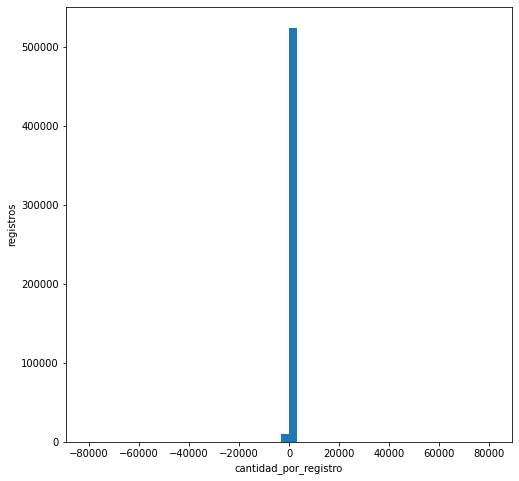

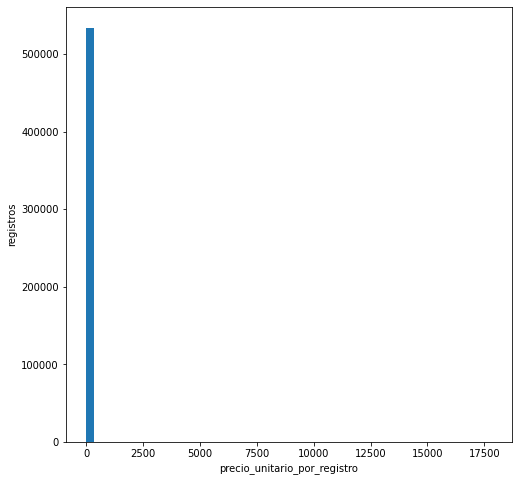

In [194]:
#Histograma y percentiles de cantidad
print('Cantidad:')

plt.figure(figsize = (8,8))
plt.hist(data_complete['cantidad'], bins=50)
plt.xlabel('cantidad_por_registro')
plt.ylabel('registros')

print(np.percentile(data_complete['cantidad'], [0.1, 0.5, 1, 3, 5, 90, 95, 97, 99])) 

print()
print()
print('Precio unitario')

plt.figure(figsize = (8,8))
plt.hist(data_complete['precio_unitario'], bins=50)
plt.xlabel('precio_unitario_por_registro')
plt.ylabel('registros')

print(np.percentile(data_complete['precio_unitario'], [0.1, 0.5, 1, 3, 5, 90, 95, 97, 99])) 


Resulta demasiado evidente la lejanía y el impacto de los valores atípicos. Sin peligro de afectar negativamente los resultados del análisis, se procederá a eliminar el último percentil de ambas mediciones, ya que estos sí impactan el análisis general de los datos, y debe tratarse de algún tipo de error o transacción no relevante para el estudio. Así mismo se considerará la eliminación del 0.1 del primer percentil, el cual eliminaría los efectos más nocivos de sus valores atípicos; es importante destacar que no se elimará más que esta cantidad de los negativos ya que su estudio también resulta relevante para este análisis, pero no se comparan en volumen con los positivos.

Cantidad:


Precio unitario


Text(0, 0.5, 'registros')

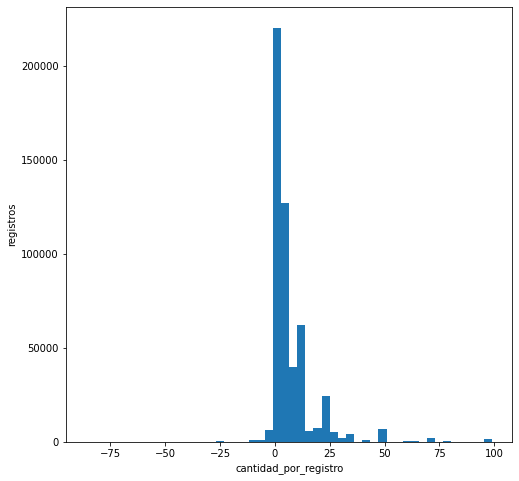

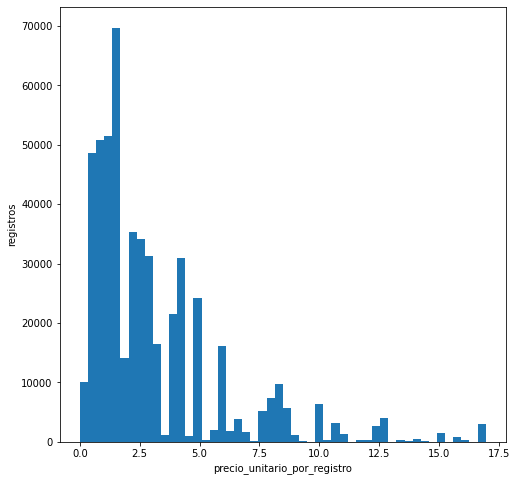

In [195]:
#Retirar registros con valores atípicos

data_filtered = data_complete[(data_complete['cantidad']<100)&(data_complete['precio_unitario']<16.98)&(data_complete['cantidad']>-87)]

print('Cantidad:')

plt.figure(figsize = (8,8))
plt.hist(data_filtered['cantidad'], bins=50)
plt.xlabel('cantidad_por_registro')
plt.ylabel('registros')
 

print()
print()
print('Precio unitario')

plt.figure(figsize = (8,8))
plt.hist(data_filtered['precio_unitario'], bins=50)
plt.xlabel('precio_unitario_por_registro')
plt.ylabel('registros')


Con esta información, que resulta mucho más acotada sin eliminar una gran cantidad de registros, procederemos a analizar una última vez la descripción de estas variables.

In [196]:
print('cantidad:')
print(data_filtered['cantidad'].describe())
print()
print()
print('precio_unitario:')
print(data_filtered['precio_unitario'].describe())

cantidad:
count    521584.000000
mean          7.453649
std          11.645985
min         -86.000000
25%           1.000000
50%           3.000000
75%          10.000000
max          99.000000
Name: cantidad, dtype: float64


precio_unitario:
count    521584.000000
mean          3.123144
std           2.951651
min           0.000000
25%           1.250000
50%           2.080000
75%           4.130000
max          16.950000
Name: precio_unitario, dtype: float64


Se eliminaron el 2.4% de los registros en total, lo cual no debe afectar al análisis final, y al contrario, se verá beneficiado por lo mismo. 

A continuación, se procederán a estudiar las siguientes hipótesis:

* Existen productos que han perdido más del 70% de su popularidad desde su inclusión, o inicios del periodo hasta el final del mismo: Esto nos ayudará a identificar productos que podríamos retirar de la oferta. 

* Alrrededor del 1% de los productos presentan más pérdidas que beneficios y conviene que sean retirados de la tienda.

* Existen productos que suelen ser comprados juntos más del 50% de las veces. Esta información puede guiarnos para establecer promociones u ofertas que incentiven su consumo conjunto y así aumentar los ingresos de la tienda.

### Existen productos que han perdido más del 70% de su popularidad

Para comenzar con la primera hipótesis obtendremos el total por registro.

In [197]:
#Obteniendo el total por registro

data_filtered['total_transaccion']=data_filtered['precio_unitario']*data_filtered['cantidad']
display(data_filtered.head())

/tmp/ipykernel_25/2206756201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['total_transaccion']=data_filtered['precio_unitario']*data_filtered['cantidad']


,transaccion_id,producto_id,descripcion_x,cantidad,fecha_transaccion,precio_unitario,cliente_id,producto_id_num,descripcion_y,total_transaccion
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850,85123,WHITE HANGING HEART T-LIGHT HOLDER,15.3
1,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 09:02:00,2.55,17850,85123,WHITE HANGING HEART T-LIGHT HOLDER,15.3
2,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 09:32:00,2.55,17850,85123,WHITE HANGING HEART T-LIGHT HOLDER,15.3
3,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2018-11-29 10:19:00,2.55,17511,85123,WHITE HANGING HEART T-LIGHT HOLDER,163.2
4,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2018-11-29 10:39:00,2.55,13408,85123,WHITE HANGING HEART T-LIGHT HOLDER,81.6


Y crearemos una columna de mes, para igualmente poder dividir mejor esta información para su estudio.

In [198]:
#Crear columna mes

data_filtered['mes'] = data_filtered['fecha_transaccion'].astype('datetime64[M]')
display(data_filtered)

/tmp/ipykernel_25/3819200902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['mes'] = data_filtered['fecha_transaccion'].astype('datetime64[M]')


,transaccion_id,producto_id,descripcion_x,cantidad,fecha_transaccion,precio_unitario,cliente_id,producto_id_num,descripcion_y,total_transaccion,mes
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850,85123,WHITE HANGING HEART T-LIGHT HOLDER,15.30,2018-11-01
1,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 09:02:00,2.55,17850,85123,WHITE HANGING HEART T-LIGHT HOLDER,15.30,2018-11-01
2,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 09:32:00,2.55,17850,85123,WHITE HANGING HEART T-LIGHT HOLDER,15.30,2018-11-01
3,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2018-11-29 10:19:00,2.55,17511,85123,WHITE HANGING HEART T-LIGHT HOLDER,163.20,2018-11-01
4,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2018-11-29 10:39:00,2.55,13408,85123,WHITE HANGING HEART T-LIGHT HOLDER,81.60,2018-11-01
...,...,...,...,...,...,...,...,...,...,...,...
534265,581492,23561,SET OF 6 RIBBONS PARTY,1,2019-12-07 10:03:00,5.79,Sin cliente,23561,SET OF 6 RIBBONS PARTY,5.79,2019-12-01
534266,581581,23561,SET OF 6 RIBBONS PARTY,6,2019-12-07 12:20:00,2.89,17581,23561,SET OF 6 RIBBONS PARTY,17.34,2019-12-01
534267,579187,23609,SET 10 CARDS SNOWY ROBIN 17099,1,2019-11-26 15:31:00,2.91,Sin cliente,23609,SET 10 CARDS SNOWY ROBIN 17099,2.91,2019-11-01
534268,579512,23617,SET 10 CARDS SWIRLY XMAS TREE 17104,2,2019-11-27 16:47:00,2.91,Sin cliente,23617,SET 10 CARDS SWIRLY XMAS TREE 17104,5.82,2019-11-01


A continuación procederemos a obtener por producto y mes totales de usuarios únicos, cantidades y total de ingresos. En este caso utilizaremos el producto por su id numérico, para englobar los distintos modelos de un mismo producto.

In [199]:
#Creación de estudio mensual por producto

data_por_mes = data_filtered.groupby(['producto_id_num','mes']).agg({'cliente_id':'nunique', 'cantidad':'sum', 'total_transaccion':'sum'}).reset_index()
display(data_por_mes)

,producto_id_num,mes,cliente_id,cantidad,total_transaccion
0,0003,2018-12-01,1,2,5.02
1,0003,2019-01-01,1,1,2.46
2,0003,2019-05-01,1,1,2.46
3,0003,2019-07-01,1,-7,0.00
4,0004,2019-04-01,1,1,16.63
...,...,...,...,...,...
31555,90214,2019-08-01,1,44,36.52
31556,90214,2019-09-01,2,48,40.26
31557,90214,2019-10-01,2,37,32.39
31558,90214,2019-11-01,3,83,101.65


Y ahora agregaremos una nueva columna con el primer mes de transacción de cada producto.

In [200]:
#Primer mes por producto

primer_mes = data_filtered.groupby('producto_id_num').agg({'mes':'min'}).reset_index()
primer_mes.columns = ['producto_id_num','mes_min']

#Unir con base

data_por_mes = data_por_mes.merge(primer_mes, on='producto_id_num')
display(data_por_mes)

,producto_id_num,mes,cliente_id,cantidad,total_transaccion,mes_min
0,0003,2018-12-01,1,2,5.02,2018-12-01
1,0003,2019-01-01,1,1,2.46,2018-12-01
2,0003,2019-05-01,1,1,2.46,2018-12-01
3,0003,2019-07-01,1,-7,0.00,2018-12-01
4,0004,2019-04-01,1,1,16.63,2019-04-01
...,...,...,...,...,...,...
31555,90214,2019-08-01,1,44,36.52,2018-11-01
31556,90214,2019-09-01,2,48,40.26,2018-11-01
31557,90214,2019-10-01,2,37,32.39,2018-11-01
31558,90214,2019-11-01,3,83,101.65,2018-11-01


Y obtenemos el mes de vida de cada mes de transacción de producto.

In [201]:
#Obtener edad en meses

data_por_mes['mes_num'] = (
    data_por_mes['mes']
    - data_por_mes['mes_min']
)/ np.timedelta64(1, 'M')

#Redondeamos por el factor de mes que crea decimales
data_por_mes['mes_num'] = (
    data_por_mes['mes_num'].round().astype('int')
)

display(data_por_mes.head(15))

,producto_id_num,mes,cliente_id,cantidad,total_transaccion,mes_min,mes_num
0,0003,2018-12-01,1,2,5.02,2018-12-01,0
1,0003,2019-01-01,1,1,2.46,2018-12-01,1
2,0003,2019-05-01,1,1,2.46,2018-12-01,5
3,0003,2019-07-01,1,-7,0.00,2018-12-01,7
4,0004,2019-04-01,1,1,16.63,2019-04-01,0
5,0069,2019-01-01,1,1,15.79,2019-01-01,0
6,0069,2019-07-01,1,-5,0.00,2019-01-01,6
7,0070,2018-12-01,1,1,12.72,2018-12-01,0
8,0070,2019-07-01,1,-8,0.00,2018-12-01,7
9,0076,2018-12-01,1,3,48.39,2018-12-01,0


A continuación obtendremos los máximos de cantidad, clientes e ingreso de los primeros tres meses (para considerar que pueden tener un periodo de divulgación) de cada producto, se les encontrará igualmente la cantidad en el mes de noviembre 2019, y se estudiará cuánto ha bajado su consumo.

In [202]:
#Encontrar máximos de primeros tres meses

data_hip1 = data_por_mes[data_por_mes['mes_num']<=2].groupby(['producto_id_num']).agg({'cliente_id':'max', 'cantidad':'max', 'total_transaccion':'max'}).reset_index()
data_hip1.columns = ['producto_id_num','cliente_id_max','cantidad_max','total_transaccion_max']

#Obtener info nov 2019

data_nov_19 = data_por_mes[data_por_mes['mes']=='2019-11-01'][['producto_id_num','cliente_id','cantidad','total_transaccion']]

#Unir tablas

data_hip1 = data_hip1.merge(data_nov_19,on='producto_id_num', how='left')

#Obtener porcentaje de diferencia

data_hip1['percent_cliente_id'] = (data_hip1['cliente_id']/data_hip1['cliente_id_max'])*100
data_hip1['percent_cantidad'] = (data_hip1['cantidad']/data_hip1['cantidad_max'])*100
data_hip1['percent_total_transaccion'] = (data_hip1['total_transaccion']/data_hip1['total_transaccion_max'])*100

display(data_hip1.head(15))

,producto_id_num,cliente_id_max,cantidad_max,total_transaccion_max,cliente_id,cantidad,total_transaccion,percent_cliente_id,percent_cantidad,percent_total_transaccion
0,0003,1,2,5.02,NaN,NaN,NaN,NaN,NaN,NaN
1,0004,1,1,16.63,NaN,NaN,NaN,NaN,NaN,NaN
2,0069,1,1,15.79,NaN,NaN,NaN,NaN,NaN,NaN
3,0070,1,1,12.72,NaN,NaN,NaN,NaN,NaN,NaN
4,0076,1,3,48.39,NaN,NaN,NaN,NaN,NaN,NaN
5,10002,18,220,189.37,NaN,NaN,NaN,NaN,NaN,NaN
6,10080,1,2,1.70,6.0,89.0,26.13,600.000000,4450.000000,1537.058824
7,10120,4,30,6.30,7.0,48.0,10.08,175.000000,160.000000,160.000000
8,10123,1,1,0.65,NaN,NaN,NaN,NaN,NaN,NaN
9,10124,1,5,2.10,1.0,8.0,3.36,100.000000,160.000000,160.000000


Podemos observar que existen productos que aumentan su popularidad e índices de consumo, pero otros que efectivamente disminuyen. A continuación observaremos todos aquellos productos que se encuentran al 30% o menos de todos sus valores con los que entraron al mercado y pueda convenir retirar de la oferta.

In [203]:
data_hip1_result=data_hip1[(data_hip1['percent_cliente_id']<=30)&(data_hip1['percent_cantidad']<=30)&(data_hip1['percent_total_transaccion']<=30)]
display(data_hip1_result)

,producto_id_num,cliente_id_max,cantidad_max,total_transaccion_max,cliente_id,cantidad,total_transaccion,percent_cliente_id,percent_cantidad,percent_total_transaccion
11,10133,12,180,113.84,1.0,-82.0,0.00,8.333333,-45.555556,0.000000
68,17090,4,42,38.10,1.0,9.0,11.25,25.000000,21.428571,29.527559
100,20665,10,50,203.74,1.0,7.0,40.53,10.000000,14.000000,19.893001
118,20694,4,10,41.21,1.0,1.0,7.46,25.000000,10.000000,18.102402
224,20886,11,58,133.44,2.0,2.0,6.08,18.181818,3.448276,4.556355
...,...,...,...,...,...,...,...,...,...,...
3075,85208,4,110,191.64,1.0,1.0,2.10,25.000000,0.909091,1.095805
3138,90060,4,5,29.74,1.0,1.0,5.82,25.000000,20.000000,19.569603
3186,90125,4,141,158.08,1.0,6.0,12.60,25.000000,4.255319,7.970648
3241,90185,6,12,50.92,1.0,2.0,8.30,16.666667,16.666667,16.300079


Finalmente visualicemos el comportamiento de estos productos en el tiempo.

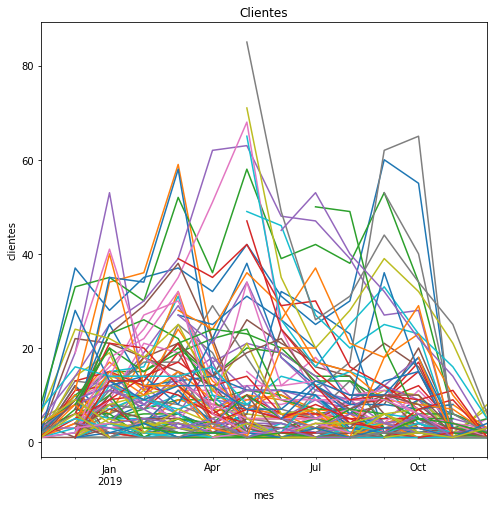

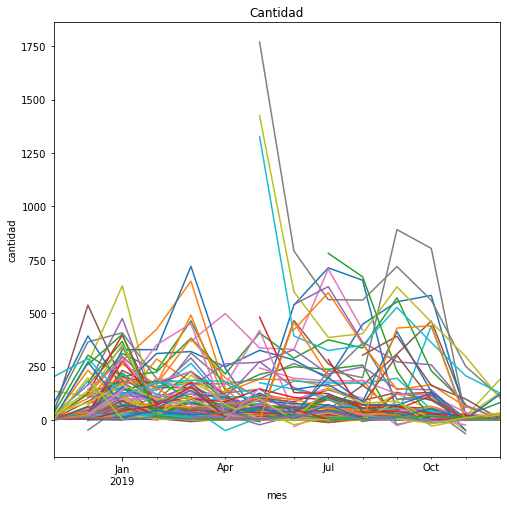

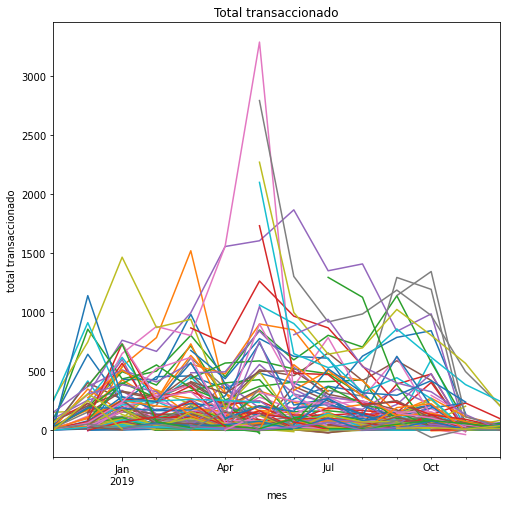

In [204]:
#Graficar comportamiento de estos productos

pivot_cliente_id = data_por_mes[data_por_mes['producto_id_num'].isin(data_hip1_result['producto_id_num'])].pivot_table(index='mes', columns='producto_id_num', values='cliente_id')

pivot_cliente_id.plot(figsize=(8, 8),legend=None, title='Clientes')
plt.xlabel("mes")
plt.ylabel("clientes")
plt.show()

pivot_cantidad = data_por_mes[data_por_mes['producto_id_num'].isin(data_hip1_result['producto_id_num'])].pivot_table(index='mes', columns='producto_id_num', values='cantidad')

pivot_cantidad.plot(figsize=(8, 8),legend=None, title='Cantidad')
plt.xlabel("mes")
plt.ylabel("cantidad")
plt.show()

pivot_total_transaccion = data_por_mes[data_por_mes['producto_id_num'].isin(data_hip1_result['producto_id_num'])].pivot_table(index='mes', columns='producto_id_num', values='total_transaccion')

pivot_total_transaccion.plot(figsize=(8, 8),legend=None, title='Total transaccionado')
plt.xlabel("mes")
plt.ylabel("total transaccionado")
plt.show()

Podemos confirmar que en efecto existen productos (139, 3.6%) que han disminuido su popularidad un 70% o más desde inicios de año o su introducción en la tienda, que en general todos estos productos tienden hacia cero, y podríamos comenzar a considerar retirarlos de la oferta de la misma, buscando productos que estén más de moda o que tengan la calidad o el precio que los clientes buscan para seguirlos comprando.

### Alrededor del 1% de los productos presentan más pérdidas que ganancias.

Para comenzar este análisis se obtendrá por producto la cantidad total de transacciones negativas, la cantidad total de devoluciones por clientes, la cantidad de perdidas no relacionadas con clientes y una comparación con lo que se vende de manera efectiva.

Comenzaremos obteniendo los totales de transacciones negativas, procederemos con las devoluciones de clientes y terminaremos con la diferencia de estas que serían los productos que representaron pérdidas no originadas por los clientes.

In [205]:
#Transacciones negativas

data_hip2 = data_filtered[data_filtered['cantidad']<0].groupby('producto_id_num').agg({'cantidad':'sum'}).reset_index()
display(data_hip2)

,producto_id_num,cantidad
0,0003,-7
1,0069,-5
2,0070,-8
3,10002,-3
4,10123,-18
...,...,...
2147,90204,-4
2148,90208,-6
2149,90209,-84
2150,90210,-38


In [206]:
#Devoluciones

devoluciones = data_filtered[(data_filtered['cantidad']<0)&(data_filtered['cliente_id']!='Sin cliente')].groupby('producto_id_num').agg({'cantidad':'sum'}).reset_index()
devoluciones.columns = ['producto_id_num','devoluciones']
display(devoluciones)

,producto_id_num,devoluciones
0,10133,-10
1,10135,-1
2,11001,-5
3,15034,-41
4,15036,-144
...,...,...
1759,90202,-24
1760,90204,-4
1761,90208,-6
1762,90209,-9


In [207]:
#Unir tablas

data_hip2 = data_hip2.merge(devoluciones, on='producto_id_num', how='left')

data_hip2.columns = ['producto_id_num','perdidas','devoluciones']

#Volver en enteros positivos y 0

data_hip2['perdidas'] = data_hip2['perdidas'].abs()
data_hip2['devoluciones'] = data_hip2['devoluciones'].abs()
data_hip2['devoluciones']=data_hip2['devoluciones'].fillna(0)

#Obtener perdidas independientes a cancelaciones

data_hip2['otras_perdidas'] = data_hip2['perdidas']-data_hip2['devoluciones']

display(data_hip2)

,producto_id_num,perdidas,devoluciones,otras_perdidas
0,0003,7,0.0,7.0
1,0069,5,0.0,5.0
2,0070,8,0.0,8.0
3,10002,3,0.0,3.0
4,10123,18,0.0,18.0
...,...,...,...,...
2147,90204,4,4.0,0.0
2148,90208,6,6.0,0.0
2149,90209,84,9.0,75.0
2150,90210,38,0.0,38.0


Obervemos gráficamente el comportamiento de las pérdidas:

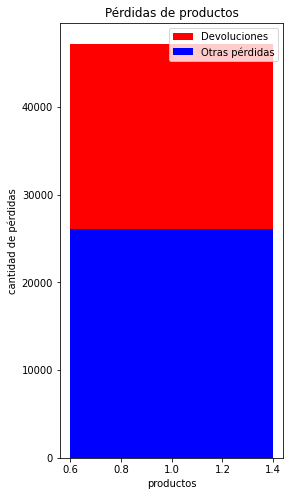

In [208]:
plt.bar(1, data_hip2['devoluciones'].sum(), color='r')
plt.bar(1, data_hip2['otras_perdidas'].sum(), bottom=data_hip2['devoluciones'], color='b')
plt.xlabel("productos")
plt.ylabel("cantidad de pérdidas")
plt.legend(["Devoluciones", "Otras pérdidas"])
plt.title("Pérdidas de productos")
plt.rcParams["figure.figsize"] = (4,8)
plt.show()

Ahora obtendremos los productos obtenidos por clientes.

In [209]:
obtenidos = data_filtered[(data_filtered['cantidad']>0)&(data_filtered['cliente_id']!='Sin cliente')].groupby('producto_id_num').agg({'cantidad':'sum'}).reset_index()
obtenidos.columns = ['producto_id_num','pedidos']
display(obtenidos)

,producto_id_num,pedidos
0,10002,583
1,10080,291
2,10120,192
3,10123,5
4,10124,33
...,...,...
3146,90209,287
3147,90210,264
3148,90211,9
3149,90212,9


In [210]:
#Unir tablas

data_hip2 = data_hip2.merge(obtenidos, on='producto_id_num', how='left')
data_hip2['pedidos']=data_hip2['pedidos'].fillna(0)

display(data_hip2)

,producto_id_num,perdidas,devoluciones,otras_perdidas,pedidos
0,0003,7,0.0,7.0,0.0
1,0069,5,0.0,5.0,0.0
2,0070,8,0.0,8.0,0.0
3,10002,3,0.0,3.0,583.0
4,10123,18,0.0,18.0,5.0
...,...,...,...,...,...
2147,90204,4,4.0,0.0,17.0
2148,90208,6,6.0,0.0,10.0
2149,90209,84,9.0,75.0,287.0
2150,90210,38,0.0,38.0,264.0


Obtener los radios entre devoluciones sobre total de transacciones negativas, devoluciones sobre pedidos y transacciones negativas sobre pedidos.

In [211]:
data_hip2['devoluciones_sobre_negativas'] = data_hip2['devoluciones']/data_hip2['perdidas']
data_hip2['devoluciones_sobre_pedidos'] = data_hip2['devoluciones']/data_hip2['pedidos']
data_hip2['perdidas_sobre_pedidos'] = data_hip2['perdidas']/data_hip2['pedidos']
display(data_hip2)

,producto_id_num,perdidas,devoluciones,otras_perdidas,pedidos,devoluciones_sobre_negativas,devoluciones_sobre_pedidos,perdidas_sobre_pedidos
0,0003,7,0.0,7.0,0.0,0.000000,NaN,inf
1,0069,5,0.0,5.0,0.0,0.000000,NaN,inf
2,0070,8,0.0,8.0,0.0,0.000000,NaN,inf
3,10002,3,0.0,3.0,583.0,0.000000,0.000000,0.005146
4,10123,18,0.0,18.0,5.0,0.000000,0.000000,3.600000
...,...,...,...,...,...,...,...,...
2147,90204,4,4.0,0.0,17.0,1.000000,0.235294,0.235294
2148,90208,6,6.0,0.0,10.0,1.000000,0.600000,0.600000
2149,90209,84,9.0,75.0,287.0,0.107143,0.031359,0.292683
2150,90210,38,0.0,38.0,264.0,0.000000,0.000000,0.143939


Filtramos resultados donde perdidas_sobre_pedidos sean mayores que 1, lo que indicaría que hubo más pérdidas que ganancias sobre ese producto.

In [212]:
data_hip2_result = data_hip2[data_hip2['perdidas_sobre_pedidos']>1]
display(data_hip2_result)

print('Productos donde las devoluciones representan más del 50% de las pérdidas')
print(data_hip2[data_hip2['devoluciones_sobre_negativas']>.5]['producto_id_num'].count())
print()
print()
print('Productos con pérdidas donde las devoluciones representan más del 50% de las pérdidas')
print(data_hip2[(data_hip2['devoluciones_sobre_negativas']>.5)&(data_hip2['perdidas_sobre_pedidos']>1)]['producto_id_num'].count())

,producto_id_num,perdidas,devoluciones,otras_perdidas,pedidos,devoluciones_sobre_negativas,devoluciones_sobre_pedidos,perdidas_sobre_pedidos
0,0003,7,0.0,7.0,0.0,0.0,NaN,inf
1,0069,5,0.0,5.0,0.0,0.0,NaN,inf
2,0070,8,0.0,8.0,0.0,0.0,NaN,inf
4,10123,18,0.0,18.0,5.0,0.0,0.0,3.600000
17,16020,7,0.0,7.0,6.0,0.0,0.0,1.166667
...,...,...,...,...,...,...,...,...
2118,90100,5,0.0,5.0,1.0,0.0,0.0,5.000000
2132,90173,28,0.0,28.0,16.0,0.0,0.0,1.750000
2136,90180,32,0.0,32.0,16.0,0.0,0.0,2.000000
2140,90191,60,0.0,60.0,22.0,0.0,0.0,2.727273


Productos donde las devoluciones representan más del 50% de las pérdidas
1493


Productos con pérdidas donde las devoluciones representan más del 50% de las pérdidas
14


La hipótesis termina resultando correcta, ya que de los 3796 productos en el catálogo 136 (3.5%) de los productos están representando más pérdidas que ganancias, de los cuales 5 son mayormente afectados por devoluciones de clientes. Igualmente resulta relevante estudiar que para 1493 productos la cantidad de devoluciones es la principal razón de las pérdidas, aquí puede existir otra oportunidad para mejorar la oferta de la tienda.

### Existen productos que son comprados juntos más del 50% de las veces

Para comenzar Obtendremos todas las parejas de ventas dentro de cada transacción y la cantidad de cada una de las parejas entre todas las transacciones.

In [41]:
#Obtener parejas
parejas_productos = data_filtered[data_filtered['cantidad']>0].groupby('transaccion_id')['producto_id_num'].agg(list).apply(lambda x:list(combinations(set(x),2))).explode()
display(parejas_productos.head(30))

transaccion_id
536365    (22752, 85123)
536365    (22752, 84029)
536365    (22752, 84406)
536365    (22752, 71053)
536365    (22752, 21730)
536365    (85123, 84029)
536365    (85123, 84406)
536365    (85123, 71053)
536365    (85123, 21730)
536365    (84029, 84406)
536365    (84029, 71053)
536365    (84029, 21730)
536365    (84406, 71053)
536365    (84406, 21730)
536365    (71053, 21730)
536366    (22632, 22633)
536367    (22622, 22749)
536367    (22622, 22623)
536367    (22622, 84879)
536367    (22622, 22745)
536367    (22622, 22310)
536367    (22622, 22748)
536367    (22622, 21777)
536367    (22622, 21754)
536367    (22622, 48187)
536367    (22622, 21755)
536367    (22622, 84969)
536367    (22749, 22623)
536367    (22749, 84879)
536367    (22749, 22745)
Name: producto_id_num, dtype: object

In [42]:
#Obtener repeticiones de pareja
conteo_parejas=parejas_productos.value_counts().reset_index()
display(conteo_parejas)

,index,producto_id_num
0,"(85099, 21931)",825
1,"(85099, 22411)",795
2,"(85099, 22386)",687
3,"(22726, 22727)",636
4,"(20725, 22383)",626
...,...,...
3989300,"(22975, 22868)",1
3989301,"(23490, 22403)",1
3989302,"(22092, 21741)",1
3989303,"(22925, 22742)",1


Para conservar únicamente valores más relevantes de venta conjunta, consideraremos únicamente aquellos casos que cuentan con más de 50 repeticiones en el año.

In [43]:
#Obteniendo parejas más relevantes
conteo_parejas_filtered=conteo_parejas[conteo_parejas['producto_id_num']>50]
display(conteo_parejas_filtered)

,index,producto_id_num
0,"(85099, 21931)",825
1,"(85099, 22411)",795
2,"(85099, 22386)",687
3,"(22726, 22727)",636
4,"(20725, 22383)",626
...,...,...
34600,"(21650, 22446)",51
34601,"(23288, 23209)",51
34602,"(22197, 21930)",51
34603,"(22556, 22457)",51


In [44]:
#Diviendo tupla de productos
conteo_parejas_filtered[['producto1','producto2']] = pd.DataFrame(conteo_parejas_filtered['index'].to_list(), columns=['producto1', 'producto2']) 
display(conteo_parejas_filtered)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,index,producto_id_num,producto1,producto2
0,"(85099, 21931)",825,85099,21931
1,"(85099, 22411)",795,85099,22411
2,"(85099, 22386)",687,85099,22386
3,"(22726, 22727)",636,22726,22727
4,"(20725, 22383)",626,20725,22383
...,...,...,...,...
34600,"(21650, 22446)",51,21650,22446
34601,"(23288, 23209)",51,23288,23209
34602,"(22197, 21930)",51,22197,21930
34603,"(22556, 22457)",51,22556,22457


A continuación obtendremos la cantidad de transacciones en las que participan los productos por separado.

In [45]:
#Obteniendo transacciones en las que participa cada producto

transacciones_por_producto = data_filtered.groupby('producto_id_num').agg({'transaccion_id':'nunique'}).reset_index()

#Unir con la tabla general

data_hip3 = conteo_parejas_filtered.merge(transacciones_por_producto, left_on='producto1', right_on='producto_id_num')

#Limpiar columnas y renombrar
data_hip3=data_hip3[['index', 'producto_id_num_x', 'producto1', 'producto2', 'transaccion_id']]
data_hip3.columns = ['parejas', 'repeticiones', 'producto1', 'producto2', 'ventas_prod_1']

#Unir para producto 2

data_hip3 = data_hip3.merge(transacciones_por_producto, left_on='producto2', right_on='producto_id_num')

#Limpiar columnas y renombrar
data_hip3=data_hip3[['parejas', 'repeticiones', 'producto1', 'producto2','ventas_prod_1', 'transaccion_id']]
data_hip3.columns = ['parejas', 'repeticiones', 'producto1', 'producto2', 'ventas_prod_1', 'ventas_prod_2']

display(data_hip3)

,parejas,repeticiones,producto1,producto2,ventas_prod_1,ventas_prod_2
0,"(85099, 21931)",825,85099,21931,2466,1144
1,"(22726, 21931)",116,22726,21931,998,1144
2,"(20725, 21931)",302,20725,21931,1551,1144
3,"(22699, 21931)",133,22699,21931,1111,1144
4,"(20727, 21931)",278,20727,21931,1269,1144
...,...,...,...,...,...,...
34600,"(22610, 22609)",52,22610,22609,205,148
34601,"(21126, 21125)",52,21126,21125,126,105
34602,"(22292, 22293)",52,22292,22293,111,122
34603,"(21534, 21528)",52,21534,21528,163,121


Procederemos a obtener los porcentajes de venta sobre cada total que implican las repeticiones de las parejas.

In [46]:
data_hip3['%prod1']=(data_hip3['repeticiones']/data_hip3['ventas_prod_1'])*100
data_hip3['%prod2']=(data_hip3['repeticiones']/data_hip3['ventas_prod_2'])*100
display(data_hip3)

,parejas,repeticiones,producto1,producto2,ventas_prod_1,ventas_prod_2,%prod1,%prod2
0,"(85099, 21931)",825,85099,21931,2466,1144,33.454988,72.115385
1,"(22726, 21931)",116,22726,21931,998,1144,11.623246,10.139860
2,"(20725, 21931)",302,20725,21931,1551,1144,19.471309,26.398601
3,"(22699, 21931)",133,22699,21931,1111,1144,11.971197,11.625874
4,"(20727, 21931)",278,20727,21931,1269,1144,21.907013,24.300699
...,...,...,...,...,...,...,...,...
34600,"(22610, 22609)",52,22610,22609,205,148,25.365854,35.135135
34601,"(21126, 21125)",52,21126,21125,126,105,41.269841,49.523810
34602,"(22292, 22293)",52,22292,22293,111,122,46.846847,42.622951
34603,"(21534, 21528)",52,21534,21528,163,121,31.901840,42.975207


Finalmente filtramos aquellas en las que al menos el 50% de las ventas totales, al menos para uno de los productos, fueron las repeticiones.

,parejas,repeticiones,producto1,producto2,ventas_prod_1,ventas_prod_2,%prod1,%prod2
0,"(85099, 21931)",825,85099,21931,2466,1144,33.454988,72.115385
21,"(20711, 21931)",268,20711,21931,514,1144,52.140078,23.426573
223,"(84923, 21931)",51,84923,21931,98,1144,52.040816,4.458042
233,"(21942, 21931)",52,21942,21931,104,1144,50.000000,4.545455
237,"(72801, 21931)",54,72801,21931,108,1144,50.000000,4.720280
...,...,...,...,...,...,...,...,...
34592,"(21788, 21789)",56,21788,21789,85,94,65.882353,59.574468
34593,"(23566, 23564)",55,23566,23564,82,75,67.073171,73.333333
34595,"(22474, 22472)",55,22474,22472,135,110,40.740741,50.000000
34598,"(23438, 23374)",54,23438,23374,108,130,50.000000,41.538462


Parejas con gran afinidad:
760



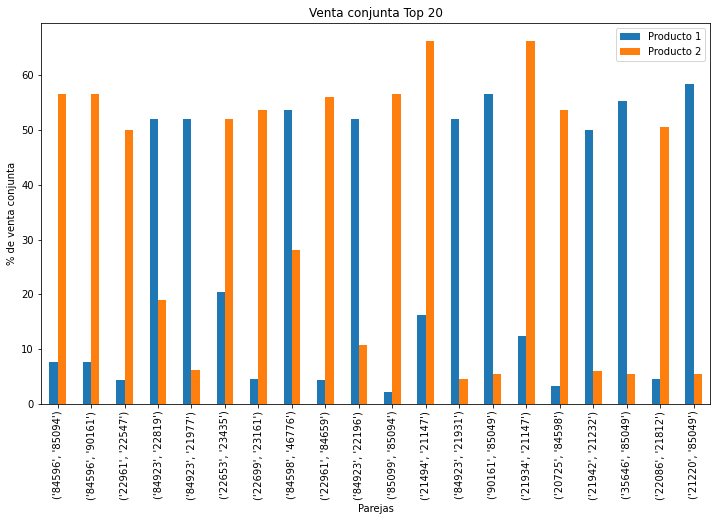

In [225]:
data_hip3_results=data_hip3[(data_hip3['%prod1']>=50)|(data_hip3['%prod2']>=50)]
data_hip3_results_top_20 = data_hip3_results.sort_values('repeticiones').head(20)
data_hip3_results_top_20['parejas']=data_hip3_results_top_20['parejas'].astype('str')
data_hip3_results_top_20 = data_hip3_results_top_20.set_index('parejas')
display(data_hip3_results)
print('Parejas con gran afinidad:')
print(data_hip3_results['%prod1'].count())
print()
data_hip3_results_top_20[['%prod1','%prod2']].plot.bar(figsize =(12, 7))
plt.xlabel("Parejas")
plt.ylabel("% de venta conjunta")
plt.legend(["Producto 1", "Producto 2"])
plt.title("Venta conjunta Top 20")
plt.show()

Con esto podemos concluir que en efecto, de acuerdo con la hipótesis existen productos que son comprados juntos más del 50% de las veces y ya los tenemos identificados para poder comenzar a realizar acciones en torno a esto: promover promociones, ofertas, paquetes, etc.

Estos productos, además represantan alrrededor del 20% del total de productos, por lo que podríamos observar un fuerte impacto en los ingresos en caso de proceder a actuar sobre esta información.

## Conclusiones generales

Tras haber realizado una limpieza de la información a través de la eliminación de duplicados, corrección de formatos, nombres de columnas y haber generados nuevas columnas con descripción de producto y mes; fue posible comenzar a analizar la información y limpiarla nuevamnte, esta vez a partir de valores atípicos. A partir de este útlimo filtrado se pudieron estudiar tres hipótesis sobre las cuales se derivaron los siguientes resultados:

* Existen productos que han perdido más del 70% de su popularidad desde su inclusión, o inicios del periodo.

* Alrrededor del 1% (2.5%) de los productos presentan más pérdidas que beneficios.

* Existen productos que suelen ser comprados juntos más del 50% de las veces.

Los primeros dos puntos resultan de gran utilidad para el negocio no únicamente para decidir hacer una limpieza de su catálogo de productos ofertados, sino para buscar sustitutos o mejores alternativas para los clientes sobre los mismos, o en todo caso estudiar si se trata de productos que ya no están de moda o que se han tornado obsoletos.

El último punto es de gran utilidad para el negocio al permitirle buscar lanzar sus propias ofertas o hacer acuerdos con los proveedores correspondientes, para insentivar que estos productos, que parecen convivir constantemente, aumenten sus ventas mutuas.

Finalmente, como área de oportunidad para el alcance de este ejercicio, podría buscarse excluir de esta investigación y estudiar de manera independiente artículos de temporada, cuyas ventas se comportan de manera muy distinta. Tienen una predisposición a venderse con productos de su misma temporalidad y parecen carecer de popularidad la mayor parte del año.

## Comentarios sobre las fuentes de información

A lo largo del desarrollo del presente proyecto se consultaron diversas fuentes de información, las cuales enlisto a continuación con una breve descripción sobre las preguntas que ayudaron a resolver.

* Documentación Matplotlib (https://matplotlib.org/): Se consultó principalmente para refrescar conocimientos relacionados con la modificación de elementos descriptivos de las gráficas como títulos y nombres de ejes.
* Documentación de Pandas (https://pandas.pydata.org/): Se consultó para refrescar conocimientos relacionados con la unión de tablas.
* Grepper (https://www.codegrepper.com/): Se investigó la manera de descargar el archivo CSV de un dataframe del jupyter notebook.
* Data science made simple (https://www.datasciencemadesimple.com/): Se consultó para refrescar conocimientos sobre algunas funciones, destacando .len() que fue requerida para las definiciones de los artículos.
* Foro StackOverflow (https://stackoverflow.com/): En este foro destaca la búsqueda de solución al problema de extraer únicamente valores numéricos de un string, lo cual fue útil para unificar productos cuyo product_id contenía letras para diferenciar el modelo.